## Goodwin Model
The Goodwin model was introduced by B. Goodwin in the 1960s to model biological processes such as circadian rhythms or phosphorylation/dephosphorylation of transcription factors. In contrast to the FitzHugh-Nagumo model, this model is much more complex because, in this case, nonlinear interactions have been introduced using the Hill function $ H(w)$. Here, the following form of the Goodwin model has been used :

$$
\frac{dx}{dt} = a H(z) - d x,
$$

$$
\frac{dy}{dt} = b x - e y,
$$

$$
\frac{dz}{dt} = c y - f z,
$$

where

$$
H(w) = \frac{K^n}{K^n + w^n} \text{ for any arbitrary variable } w.
$$

The variables $ x $, $y $, and $ z $ represent the dynamic variables specific to the system. For example, if the system under study is circadian rhythm, they can represent clock-mRNA, clock-protein, and a repressor. The coefficients $ a $, $ b $, $ c $, $ d $, $ e $, and $ f $ represent model parameters.

### Parameters

- $ a = 1 $
- $ b = 1 $
- $ c = 1 $
- $ d = 0.1 $
- $ e = 0.1 $
- $ f = 0.1 $
- $ n = 10 $
- $K = 1 $
    

In [1]:
import sys
print(sys.version)
print("--"* 60)
print(sys.executable)
print("--"* 60)

3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
------------------------------------------------------------------------------------------------------------------------
/home/alka23224/miniconda3/envs/tiseanpy/bin/python
------------------------------------------------------------------------------------------------------------------------


In [2]:
# -------------------------------
# Current working directory
# -------------------------------
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/4_Chapter_4_PyTISEAN


In [3]:
# -------------------------------
# Create a Folder for Plots
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots_2")
os.makedirs(plot_dir, exist_ok=True) 

In [4]:
# Import necessary libraries
import numpy as np   
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp 

In [5]:
import tempfile
import pytisean.pytisean
# point pytisean’s temp‐dir to whatever tempfile.gettempdir() returns
pytisean.pytisean.DIRSTR = tempfile.gettempdir()
from pytisean import tiseano, tiseanio

In [6]:
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Import helper
from plot_utils import set_plot_style, set_spines_black, set_spines_black_3d

In [7]:
# -------------------------------
#  Generate the Training Data
# --------------------------------
a, b, c = 1, 1, 1
d, e, f = 0.1, 0.1, 0.1
n, K = 10, 1
# Define the Goodwin Model
def goodwin_model(t,state,a,b,c,d,e,f,n,K):
    x, y, z = state 
    # Hill function
    H_z = K**n/(K**n + z**n) 

    dx_dt = a*H_z - d*x
    dy_dt = b*x - e*y
    dz_dt = c*y - f*z  
    return [dx_dt, dy_dt, dz_dt]

# Parameters for ODE Integrator
t_max = 1000  # Maximum time for the simulation
dt = 0.01  # The time step
t_train = np.arange(0, t_max, dt) # Time points for simulation
X0 =[0.01, 0, 0]  # Initial state of the system

# Solve with solve_ivp
X = solve_ivp(
    goodwin_model,
    t_span=[0, t_max],
    y0=X0,
    args=(a,b,c,d,e,f,n,K),
    t_eval=t_train,  
    method='LSODA'    
)

x_train = X.y.T  

In [8]:
# Print sizes of t_train, X 
print("Size of t_train:", t_train.shape)
print("Size of x_train:", x_train.shape)

Size of t_train: (100000,)
Size of x_train: (100000, 3)


In [9]:
x_t = x_train[:,0] # Choose x(t), a scaler time series

In [10]:
N = len(x_t)  # Get the length of the time series
print("The length of the time series x(t) is:", N)

The length of the time series x(t) is: 100000


## Time Delay

In [11]:
autocor_information, msg = tiseanio('autocor','-V',0, data=x_t)
autocor_information.shape

['autocor', '/tmp/pytisean_temp_2025-07-07-14-39-44_d_yt74oj.dat', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-39-44_no02wtk9.dat']



(100000, 2)

In [12]:
time_delays = autocor_information[:, 0]  # The lag values (time delays)
autocorrelation_values = autocor_information[:, 1]  # The autocorrelation values
# Find time delay based on first crossing a threshold, e.g., 1/e
threshold = np.exp(-1)  # 1/e ≈ 0.37 
# Find the first index where autocorrelation falls below or equal to the threshold
time_delay_idx = np.where(autocorrelation_values <= threshold)[0][0]  # First crossing of 1/e
time_delay_value = time_delays[time_delay_idx]


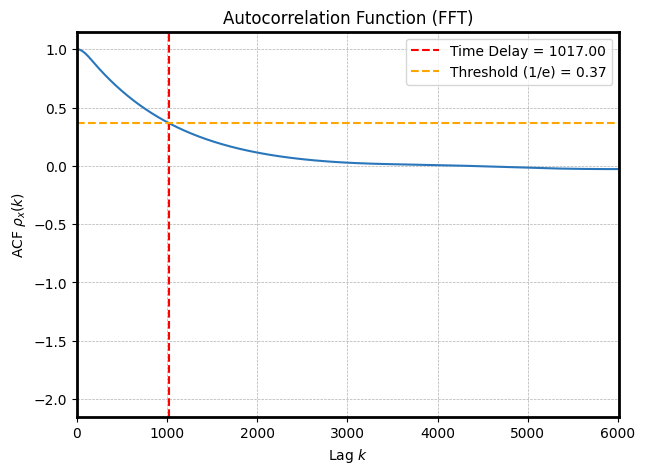

Selected  delay: 1017.0


In [13]:
# Plot the autocorrelation and mark the selected time delay
bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('Autocorrelation Function (FFT)')
ax.plot(time_delays, autocorrelation_values, color=bluish)
ax.set_xlabel(r'Lag $k$')
ax.set_ylabel(r'ACF $\rho_x(k)$')
plt.grid(True, which='both', ls='--', lw=0.5)

# Mark the time delay
ax.axvline(x=time_delay_value, color='r', linestyle='--', label=f'Time Delay = {time_delay_value:.2f}')
# Mark the threshold
ax.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold (1/e) = {threshold:.2f}')
set_spines_black(ax)
ax.legend()
ax.set_xlim(0, time_delay_idx + 5000) 
plt.savefig("Plots_2/TimeDelay_Goodwin_model.pdf", bbox_inches="tight")
plt.show()
print(f"Selected  delay: {time_delay_value}")


## Embedding Dimesion

['false_nearest', '/tmp/pytisean_temp_2025-07-07-14-39-53_s99arzj2.dat', '-m', '1', '-M', '1,6', '-d', '1017', '-f', '2', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-39-53_m603hmnn.dat']



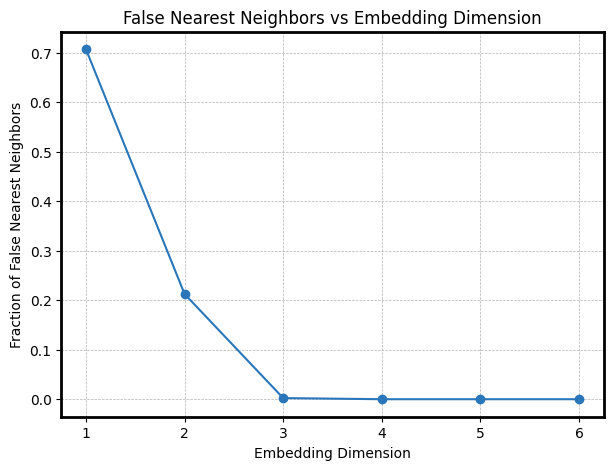

In [14]:
fnn_information, msg = tiseanio('false_nearest', '-m', 1, '-M', '1,6', '-d', 1017, '-f', 2, '-V', 0, data=x_t)
# Plot the fraction of false nearest neighbors against embedding dimension
embedding_dimensions = fnn_information[:, 0]  # First column: embedding dimensions
fnn_values = fnn_information[:, 1]            # Second column: fraction of false nearest neighbors

bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('False Nearest Neighbors vs Embedding Dimension')
ax.plot(embedding_dimensions, fnn_values, color=bluish, marker='o')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Fraction of False Nearest Neighbors')
set_spines_black(ax)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.savefig("Plots_2/Embedding_Dimension_Goodwin_model.pdf", bbox_inches="tight")
plt.show()


In [15]:
fnn_values

array([7.070545e-01, 2.125498e-01, 2.321668e-03, 2.129971e-05,
       2.129971e-05, 2.129971e-05])

In [16]:
## Time Delay = 1017
## Embedding Dimension = 3

In [17]:
# To generate delay vectors
delay_information, msg = tiseanio('delay', '-m', 3, '-d', 1017, '-V', 0, data=x_t)

['delay', '/tmp/pytisean_temp_2025-07-07-14-40-01_ve_3au3q.dat', '-m', '3', '-d', '1017', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-40-01_la4ve8se.dat']



In [18]:
delay_information

array([[0.2755483 , 0.7619116 , 0.01      ],
       [0.2752729 , 0.7611501 , 0.019985  ],
       [0.2749977 , 0.7603893 , 0.02996003],
       ...,
       [0.01110294, 0.02955388, 0.04094607],
       [0.01109249, 0.02952585, 0.04101008],
       [0.01108206, 0.02949785, 0.04107393]])

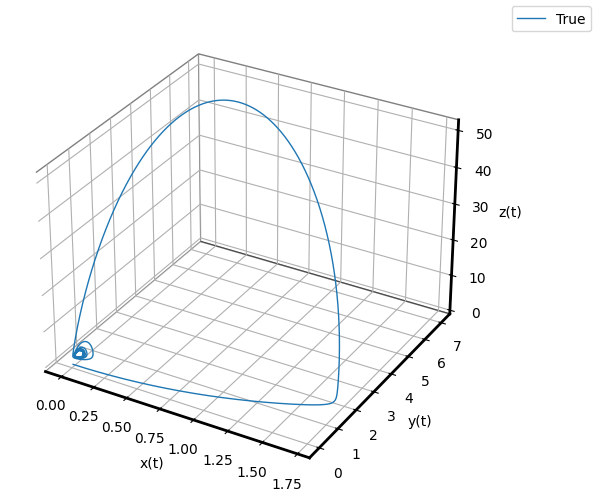

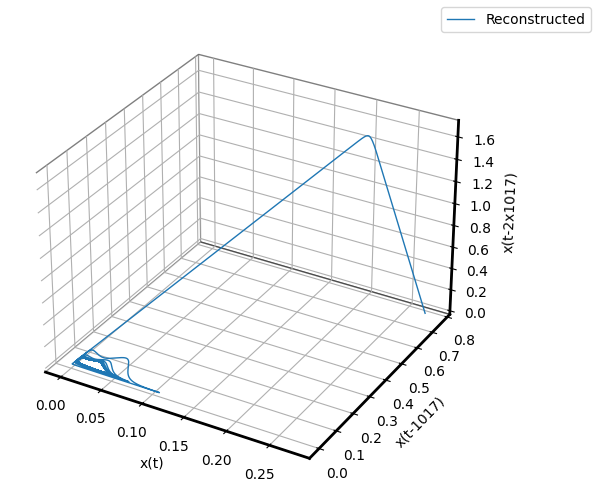

In [19]:
# Phase Digram
# 1) True Phase Digram
fig1 = plt.figure(figsize=(7, 5), dpi=100)
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(
    x_train[:, 0], x_train[:, 1], x_train[:, 2],
    lw=1.0, label='True'
)
ax1.set(xlabel='x(t)', ylabel='y(t)', zlabel='z(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
fig1.legend()
set_spines_black_3d(ax1)
fig1.tight_layout()
plt.savefig("Plots_2/True_phase_Goodwin_model.pdf", bbox_inches="tight")
plt.show()
# 2) Reconstructed Phase Digram: [x(t), x(t-tau), x(t- 2. tau)]
fig2 = plt.figure(figsize=(7, 5), dpi=100)
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(
     delay_information[:, 0],
     delay_information[:, 1],
     delay_information[:, 2],
     lw=1.0, label='Reconstructed')
ax2.set(xlabel='x(t)', ylabel='x(t-1017)', zlabel='x(t-2x1017)')
fig2.legend()
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black_3d(ax2)
fig2.tight_layout()
plt.savefig("Plots_2/Reconstructed_phase_Goodwin_model.pdf", bbox_inches="tight")
plt.show()

In [20]:
# Extracting the Latent Features

In [21]:
# Perform SVD 
U, S, Vt = np.linalg.svd(delay_information,  full_matrices = False)

In [22]:
print(U)

[[-0.00735969 -0.06587702 -0.0523033 ]
 [-0.00755032 -0.06544128 -0.05198255]
 [-0.00774076 -0.06500596 -0.05166212]
 ...
 [-0.00109021 -0.00108129 -0.00088647]
 [-0.00109121 -0.00107646 -0.00088285]
 [-0.00109221 -0.00107164 -0.00087925]]


In [23]:
print("Shape of embedded data:", delay_information.shape)
print("Shape of U:", U.shape)
print("Shape of S:", S.shape)
print("Shape of Vt:", Vt.shape)

Shape of embedded data: (97966, 3)
Shape of U: (97966, 3)
Shape of S: (3,)
Shape of Vt: (3, 3)


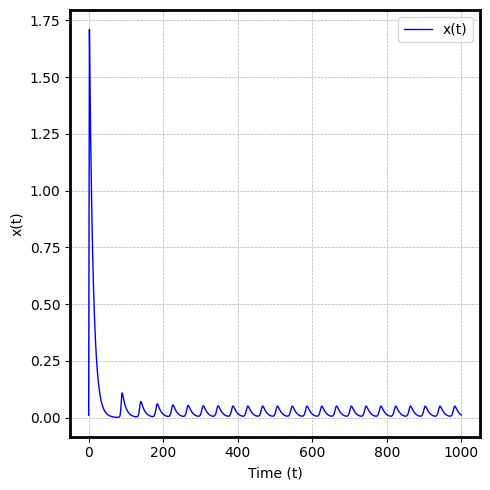

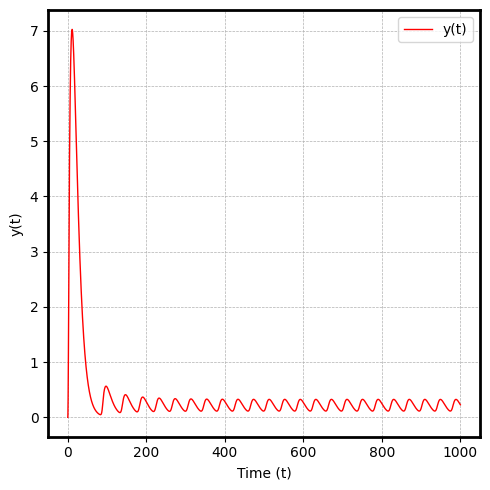

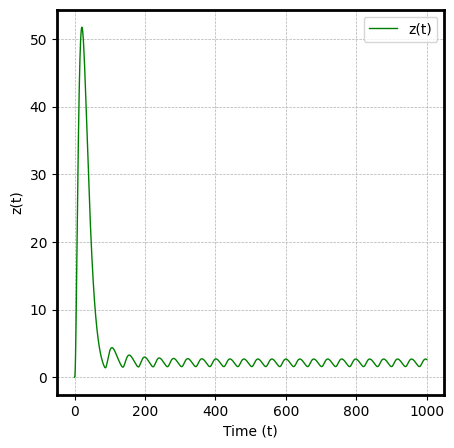

In [24]:
# Plot the original time series obtained corresponding to each variable
# First variable x(t)
fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
ax1.plot(t_train, x_train[:, 0], color='b', lw=1.0, label='x(t)')
ax1.set(xlabel='Time (t)', ylabel='x(t)')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.show()


# Second variable y(t)
fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=100)
ax2.plot(t_train, x_train[:, 1], color='r', lw=1.0, label='y(t)')
ax2.set(xlabel='Time (t)', ylabel='y(t)')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.show()

# Second variable z(t)
fig3, ax3 = plt.subplots(figsize=(5, 5), dpi=100)
ax3.plot(t_train, x_train[:, 2], color='g', lw=1.0, label='z(t)')
ax3.set(xlabel='Time (t)', ylabel='z(t)')
ax3.legend(loc='best')
ax3.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax3)
fig2.tight_layout()
plt.show()


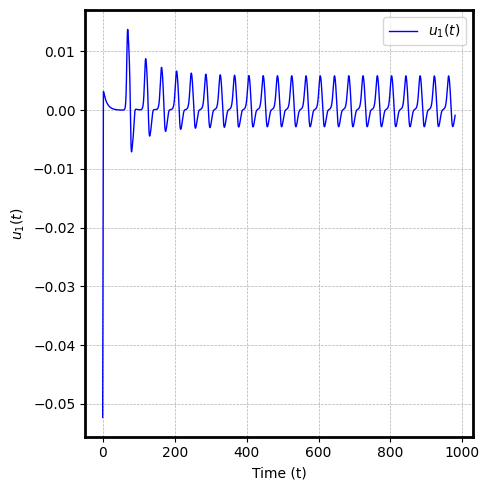

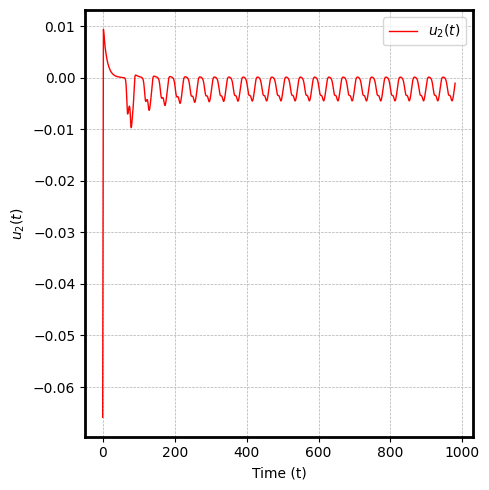

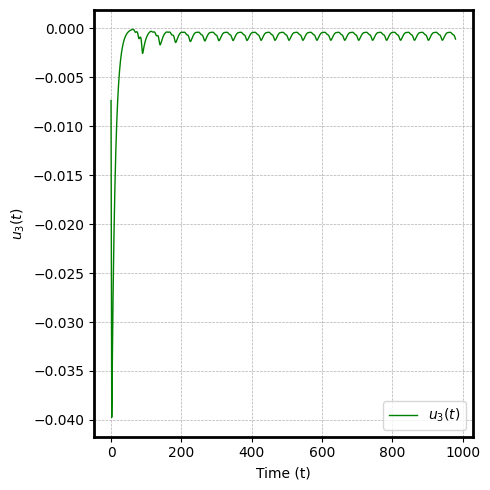

In [25]:
# Plot the time series obtained using SVD
min_len = min(len(t_train), len(U[:, 0]))

fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
ax1.plot(t_train[:min_len], U[:, 2], color='b', lw=1.0, label='$u_1(t)$')
ax1.set(xlabel='Time (t)', ylabel='$u_1(t)$')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.savefig("Plots_2/Latent_u1_Goodwin_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=100)
ax2.plot(t_train[:min_len], U[:, 1], color='r', lw=1.0, label='$u_2(t)$')
ax2.set(xlabel='Time (t)', ylabel='$u_2(t)$')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.savefig("Plots_2/Latent_u2_Goodwin_Nagumo_model.pdf", bbox_inches="tight")
plt.show()



fig3, ax3 = plt.subplots(figsize=(5, 5), dpi=100)
ax3.plot(t_train[:min_len], U[:, 0], color='g', lw=1.0, label='$u_3(t)$')
ax3.set(xlabel='Time (t)', ylabel='$u_3(t)$')
ax3.legend(loc='best')
ax3.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax3)
fig3.tight_layout()
plt.savefig("Plots_2/Latent_u3_Goodwin_Nagumo_model.pdf", bbox_inches="tight")
plt.show()


#####################################################################################################################################################